# Import libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import time

# for audio
from IPython.display import Audio
import librosa

# for preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# for modeling
import tensorflow as tf
from sklearn.metrics import classification_report
!pip install transformers
from transformers import AutoFeatureExtractor, ASTModel
import torch

# For visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# For drive access
from google.colab import drive
import os
drive.mount('/content/drive')

  Using cached transformers-4.31.0-py3-none-any.whl (7.4 MB)
  Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.8 MB/s eta 0:00:00
Mounted at /content/drive


# Load train data csv file

In [2]:
df = pd.read_csv('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/train_val.csv')

df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train
1,eaywag1,eaywag1/XC675682.ogg,call,eaywag1/XC675682.npy,good,35.657000,RU,EUROPE,train
2,eaywag1,eaywag1/XC722533.ogg,blank,eaywag1/XC722533.npy,good,58.104000,RU,EUROPE,train
3,eaywag1,eaywag1/XC673617.ogg,call,eaywag1/XC673617.npy,poor,18.756000,GB,EUROPE,train
4,eaywag1,eaywag1/XC675935.ogg,call,eaywag1/XC675935.npy,good,16.666000,RU,EUROPE,train


In [3]:
len(df)

940

In [4]:
train_df = df[df['data'] == 'train']
train_df = train_df.sample(frac=1, random_state=1234)
train_df.head()

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
385,comsan,comsan/XC746957.ogg,blank,comsan/XC746957.npy,good,6.112000,DK,EUROPE,train
61,eaywag1,eaywag1/XC658750.ogg,call,eaywag1/XC658750.npy,good,49.680000,DE,EUROPE,train
271,comsan,comsan/XC725160.ogg,blank,comsan/XC725160.npy,good,6.635000,EE,EUROPE,train
367,comsan,comsan/XC430908.ogg,call,comsan/XC430908.npy,good,15.255500,RU,EUROPE,train
58,eaywag1,eaywag1/XC507677.ogg,call,eaywag1/XC507677.npy,poor,17.397562,GB,EUROPE,train


# Extract the last hidden state from AST pre-trained model as feature

https://huggingface.co/docs/transformers/main/en/model_doc/audio-spectrogram-transformer#transformers.ASTModel

In [5]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

In [6]:
train_features = []

for filename in train_df['filename_npy']:
  audio = np.load('/content/drive/MyDrive/207/207-Project/data/train/librosa_loaded/' + filename)
  inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt")
  with torch.no_grad():
    outputs = model(**inputs)
  last_hidden_states = outputs.last_hidden_state
  last_hidden_states = last_hidden_states.squeeze(0) # sqeeuze last_hidden_states of shape [1, 1214, 768] to [1214, 768]
  train_features.append(last_hidden_states)

train_features = np.array(train_features)

# train_features is a list containing n_samples of last_hidden_states, each of shape [1214,768]
# stack each last_hidden_states so the train_features becomes shape (n_samples, 1214,768)
train_features = np.stack(train_features, axis=0)

display(train_features.shape)
display(train_features[0])

<ipython-input-6-3c76e802dd60>:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_features = np.array(train_features)
<ipython-input-6-3c76e802dd60>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_features = np.array(train_features)


(657, 1214, 768)

array([[-0.6389767 ,  0.92976457, -1.6062033 , ..., -0.25147974,
         0.44703245,  0.6225577 ],
       [-0.05258327,  0.8869369 , -1.6951116 , ...,  0.57083005,
        -0.85489315,  0.7443621 ],
       [ 0.42554712,  0.5025224 ,  0.68126094, ..., -0.2657997 ,
         0.21347678,  0.578808  ],
       ...,
       [ 0.16377406,  1.0624378 , -3.0339096 , ..., -0.12160379,
        -0.8683414 , -0.12326998],
       [-0.01265558,  0.8763662 , -2.0558367 , ..., -0.47873136,
        -1.1151869 , -0.23724823],
       [ 0.40565866,  1.0861267 , -1.3002502 , ..., -0.23296154,
        -1.0708343 ,  0.23470043]], dtype=float32)

In [7]:
del feature_extractor
del model

# Extract classes

In [8]:
train_y = train_df['primary_label']
train_y.shape

(657,)

In [9]:
del df
del train_df
del AutoFeatureExtractor
del ASTModel
del inputs
del outputs
del filename
del audio
del last_hidden_states
del torch

# Encode classes

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder().fit(train_y)
train_y = label_encoder.transform(train_y)
classes = list(label_encoder.inverse_transform([0,1,2]))
classes

['barswa', 'comsan', 'eaywag1']

In [11]:
print(len(train_y))
print(train_y[:5])
print(classes)

657
[1 2 1 1 2]
['barswa', 'comsan', 'eaywag1']


In [12]:
del LabelEncoder
del label_encoder

In [13]:
%who

Audio	 MinMaxScaler	 classes	 classification_report	 drive	 librosa	 np	 os	 pd	 
plt	 sns	 tf	 time	 train_features	 train_y	 


# shuffle the data before feeding into the model

In [14]:
train_len = len(train_y)
np.random.seed(1234)
train_indices = np.random.permutation(train_len)
train_features = np.array([train_features[i] for i in train_indices])
train_y = np.array([train_y[i] for i in train_indices])

display(train_y.shape)
display(train_y[:5])

(657,)

array([1, 0, 1, 2, 0])

# build a 1D-CNN model using last_hidden_states

In [15]:
train_results = {}

In [16]:
train_features.shape

(657, 1214, 768)

In [17]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv1D(
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool1D(
    pool_size=2,
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv1D(
    filters=64,
    kernel_size=5,
    strides=1,
    padding='same',
    name='conv_2',
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool1D(
    pool_size=2, name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1',
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=3 to get a 3 output unit (remember it's 3 species)
model.add(tf.keras.layers.Dense(
    units=3,
    name='fc_2',
    activation=None))


# build model and print summary
model.build(input_shape=(None,train_features.shape[1],train_features.shape[2]))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 1214, 32)          122912    
                                                                 
 pool_1 (MaxPooling1D)       (None, 607, 32)           0         
                                                                 
 conv_2 (Conv1D)             (None, 607, 64)           10304     
                                                                 
 pool_2 (MaxPooling1D)       (None, 303, 64)           0         
                                                                 
 flatten (Flatten)           (None, 19392)             0         
                                                                 
 fc_1 (Dense)                (None, 1024)              19858432  
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_logits=True because our last layer does not apply sigmoid
              metrics=['accuracy'])

In [19]:
history = model.fit(
   x=train_features,
   y=train_y,
   epochs=20,
   batch_size=32,
   verbose=0)

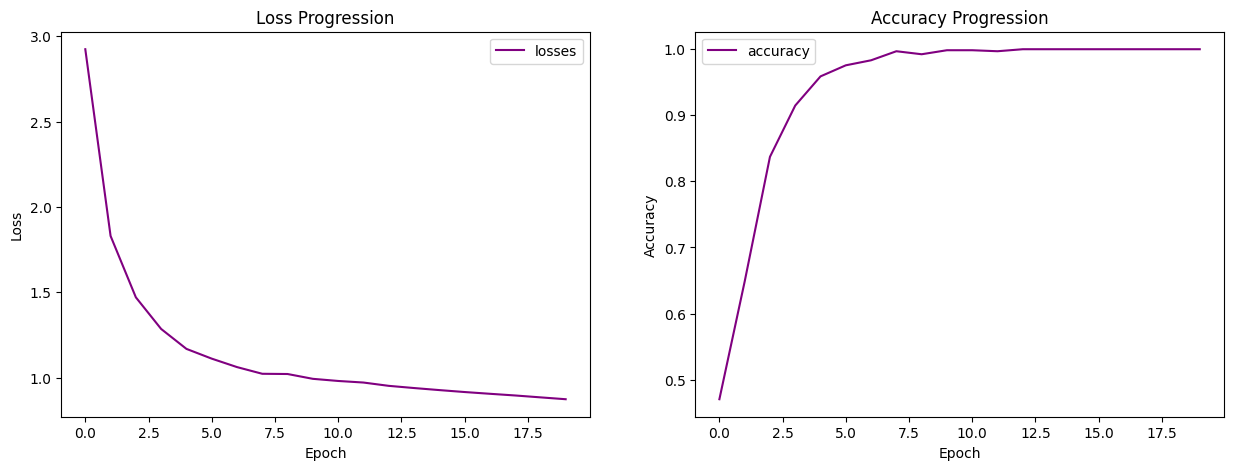

In [20]:
# visualize the loss and accuracy
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

axes[0].plot(history.history['loss'], color='purple', label='losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(history.history['accuracy'], color='purple', label='accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()
plt.show()

In [21]:
model.save('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/class_methods/models_h5/9b.model.h5')